# Time Series Momentum

## Introduction

Time Series Momentum or trend following strategies involve looking at past historical data and predict the performance of instruments. Here, I explore ideas from the Research Paper _"Time Series Momentum", Tobias J. Moskowitz, Yao Hua Ooi, Lasse Heje Pedersen_.

In [476]:
import pandas as pd
import numpy as np
import math
import utilities as utils
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as datetime
from pathlib import Path 

In [477]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting the data for Indices 

Equities:
SPX - S&P 500 Index
EAFE - MSCI EAFE Index - Developed countries equities excl. US
MXEF - MSCI Emerging Markets Index

Commodities:
SPGSCITR - S&P GSCI Total Return

Fixed Income:
JPMTUS - JPMorgan BetaBuilders US Treasury Bond

Currencies:
DXY - Dollar Index

Risk-free Rate:
3M Treasury Rate

In [458]:
price_data = data.get_prices()

In [459]:
price_data.head()

TICKER,Commodities|SPGSCITR,Equities|EAFE,Equities|MXEF,Equities|SPX,Currencies|DXY,Fixed Income|JPMTUS,3M Treasury Rate
DATE_,,,,,,,
2004-01-21,4748.7422,1338.01,465.47,1147.62,86.34,350.108,0.876049
2004-01-22,4735.1782,1347.29,465.64,1143.94,85.82,351.369,0.865923
2004-01-23,4734.6851,1345.41,467.90,1141.55,86.56,349.589,0.877552
2004-01-26,4654.7021,1331.10,469.77,1155.37,87.25,348.381,0.901515
2004-01-27,4625.3008,1336.02,471.43,1144.05,86.25,349.447,0.902789


### Return Series for lookback and holding periods

Calculates cummulative excess returns for the period using 3M Treasury Bill rate as risk-free rate

In [460]:
lookback_period = 12 #months
holding_period = 1 #month

In [461]:
excess_rets_lb, excess_rets_hp = utils.calc_returns(price_data, lookback_period, holding_period)

<AxesSubplot:>

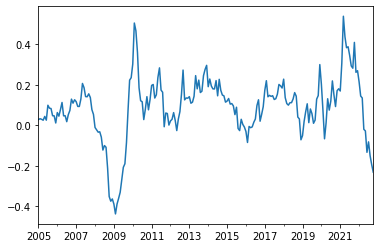

In [505]:
excess_rets_lb['Equities|SPX'].plot()

<AxesSubplot:>

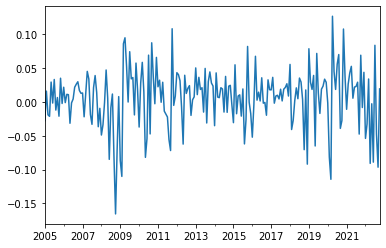

In [506]:
excess_rets_hp['Equities|SPX'].plot()

### Ex Ante Volatility Calculations

Uses same methodology as in the paper. 
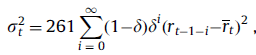

In [495]:
delta = 60/61

In [496]:
ea_vol = utils.calc_ex_ante_volatilities(price_data, delta)

<AxesSubplot:xlabel='Unnamed: 0'>

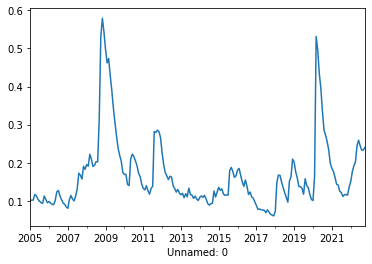

In [507]:
ea_vol['Equities|SPX'].plot()

### Build Strategy Returns

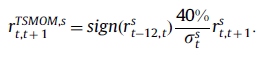

In [498]:
TSMOM_rets = np.sign(excess_rets_lb)*(0.4/ea_vol)*excess_rets_hp

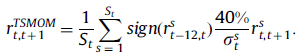

In [499]:
TSMOM_rets['Aggregate'] = TSMOM_rets.mean(axis=1)

In [500]:
TSMOM_rets_cum = (1+TSMOM_rets).cumprod()

# Performance Assessment

### Cumulative Returns of strategy

<AxesSubplot:>

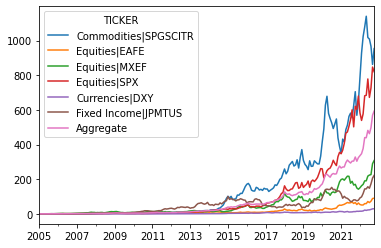

In [508]:
TSMOM_rets_cum.plot()

### Strategy vs Index Peformance 

In [521]:
strat_perf = pd.DataFrame(index=['Excess Return', 'Volatility', 'Sharpe Ratio'], columns=TSMOM_rets.columns)
strat_perf.loc['Excess Return'] = 12*TSMOM_rets.mean(axis=0)
strat_perf.loc['Volatility'] = np.sqrt(12)*TSMOM_rets.std(axis=0)
strat_perf.loc['Sharpe Ratio'] = strat_perf.loc['Excess Return']/strat_perf.loc['Volatility']

In [522]:
strat_perf

TICKER,Commodities|SPGSCITR,Equities|EAFE,Equities|MXEF,Equities|SPX,Currencies|DXY,Fixed Income|JPMTUS,Aggregate
Excess Return,0.463953,0.329307,0.41917,0.431304,0.275026,0.382662,0.38357
Volatility,0.3896,0.387798,0.435488,0.316273,0.407789,0.394069,0.205023
Sharpe Ratio,1.19084,0.84917,0.96253,1.36371,0.674433,0.971053,1.87086


In [523]:
index_perf = pd.DataFrame(index=['Excess Return', 'Volatility', 'Sharpe Ratio'], columns=excess_rets_hp.columns)
index_perf.loc['Excess Return'] = 12*excess_rets_hp.mean(axis=0)
index_perf.loc['Volatility'] = np.sqrt(12)*excess_rets_hp.std(axis=0)
index_perf.loc['Sharpe Ratio'] = index_perf.loc['Excess Return']/index_perf.loc['Volatility']

In [524]:
index_perf

TICKER,Commodities|SPGSCITR,Equities|EAFE,Equities|MXEF,Equities|SPX,Currencies|DXY,Fixed Income|JPMTUS
Excess Return,0.00784492,0.0184444,0.0470371,0.0729671,0.0209799,0.0268204
Volatility,0.236547,0.167893,0.20877,0.14952,0.0762357,0.0485506
Sharpe Ratio,0.0331644,0.109858,0.225306,0.48801,0.275197,0.552421


### 3 year Rolling Performance Analysis

In [525]:
#strat_roll_rets = ((1+TSMOM_rets).rolling(window=36).apply(np.prod) - 1)**(1/3)-1
strat_roll_rets = (1 + TSMOM_rets.rolling(window=36).mean())**12 -1
strat_roll_vol = np.sqrt(12)*TSMOM_rets.rolling(window=36).std()
strat_roll_sharpe = strat_roll_rets.div(strat_roll_vol.values)

<AxesSubplot:>

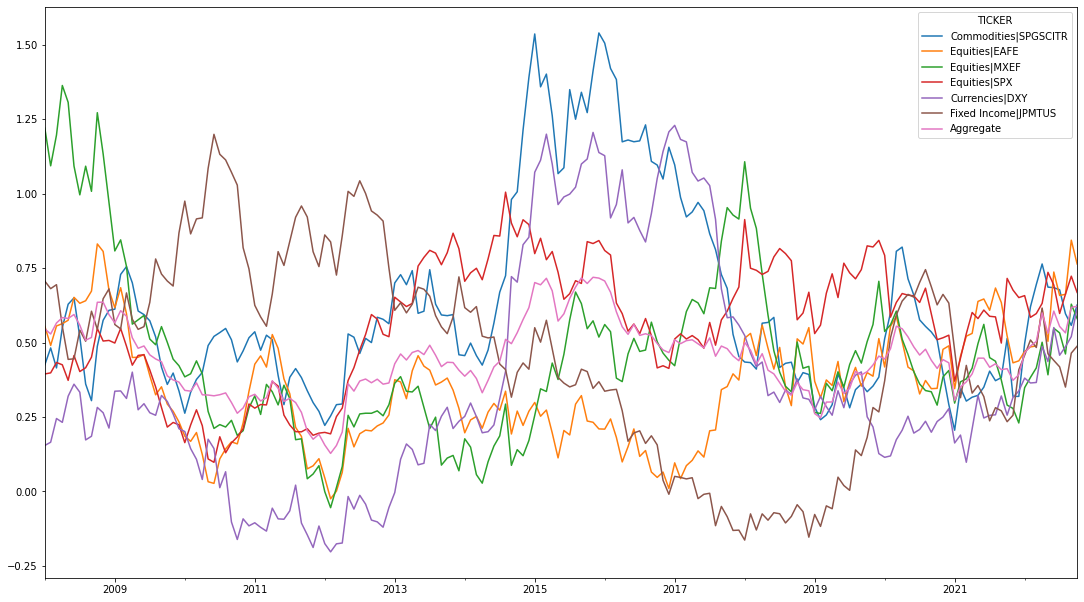

In [526]:
strat_roll_rets.loc['2008':].plot(figsize=(18.5, 10.5))

<AxesSubplot:>

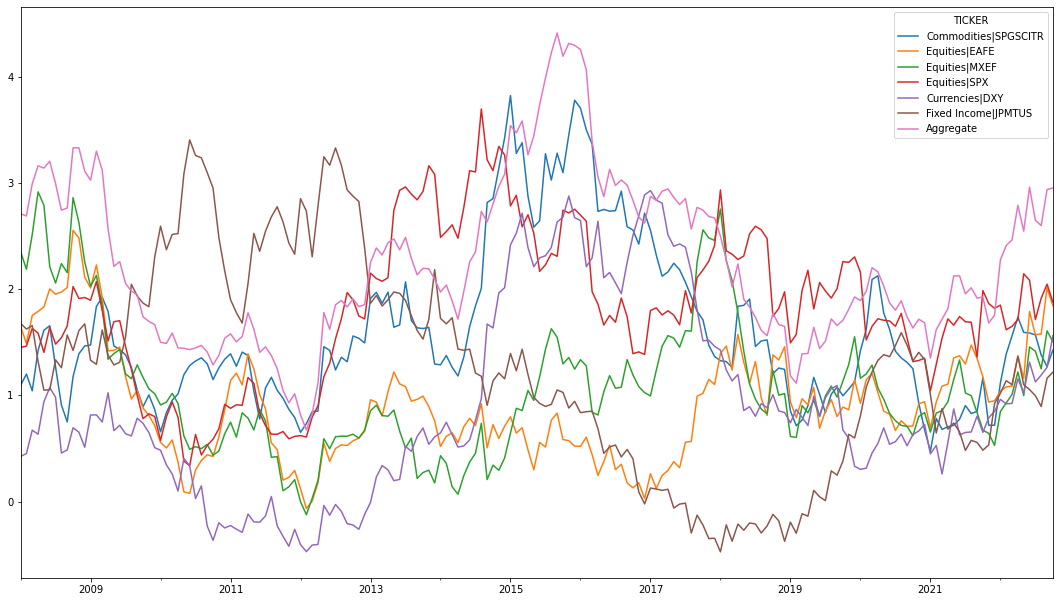

In [527]:
strat_roll_sharpe.loc['2008':].plot(figsize=(18.5, 10.5))

In [528]:
index_roll_rets = (1 + excess_rets_hp.rolling(window=36).mean())**12 -1
index_roll_vol = np.sqrt(12)*excess_rets_hp.rolling(window=36).std()
index_roll_sharpe = index_roll_rets.div(index_roll_vol.values)

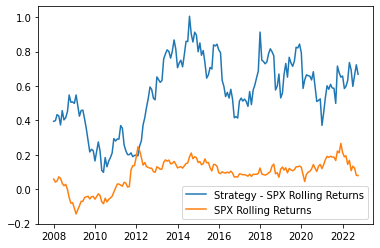

In [536]:
plt.plot(strat_roll_rets.loc['2008':].index.to_timestamp(), strat_roll_rets.loc['2008':,'Equities|SPX'], label = "Strategy - SPX Rolling Returns")
plt.plot(index_roll_rets.loc['2008':].index.to_timestamp(), index_roll_rets.loc['2008':,'Equities|SPX'], label = "SPX Rolling Returns")
plt.legend()
plt.show()

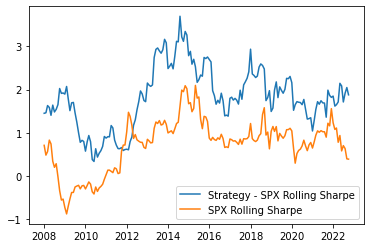

In [537]:
plt.plot(strat_roll_sharpe.loc['2008':].index.to_timestamp(), strat_roll_sharpe.loc['2008':,'Equities|SPX'], label = "Strategy - SPX Rolling Sharpe")
plt.plot(index_roll_sharpe.loc['2008':].index.to_timestamp(), index_roll_sharpe.loc['2008':,'Equities|SPX'], label = "SPX Rolling Sharpe")
plt.legend()
plt.show()